In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('Data/dataset-case-iqvia.csv', sep=',')

df.head()

,week_dt,dsupp_id,product_id,region_nm,units_qty,product_attr_1,product_attr_2,product_attr_3
0,2024-03-31,6,233.0,Norte,6.0,B,C,B24
1,2024-03-01,6,233.0,Norte,1.0,B,C,B24
2,2024-08-01,6,233.0,Norte,1.0,B,C,B24
3,2024-09-29,6,233.0,Norte,1.0,B,C,B24
4,2024-05-01,6,233.0,Norte,3.0,B,C,B24


---

# EDA

## Dicionário de variáveis:
- week_dt: data correspondente ao primeiro dia da semana.
- dsupp_id: código de identificação do distribuidor do produto.
- product_id: código de identificação do produto.
- region_nm: macrorregião do ibge cuja loja, na qual o produto foi vendido, está situada.
- units_qty: quantidade de unidades vendidas na semana.
- product_attr_1, product_attr_2 e product_attr_3: atributos específicos dos produtos.

In [3]:
# Convertendo para datetime
df['week_dt'] = pd.to_datetime(df['week_dt'])

df = df.sort_values('week_dt', ascending=True).reset_index(drop=True)

df['week_dt']

0        2022-11-01
1        2022-11-01
2        2022-11-01
3        2022-11-01
4        2022-11-01
            ...    
120585   2024-10-27
120586   2024-10-27
120587   2024-10-27
120588   2024-10-27
120589   2024-10-27
Name: week_dt, Length: 120590, dtype: datetime64[ns]

In [4]:
print("="*50 + " Default Checking " + "="*50)
print("NaN Values:")
for column in df.columns:
    if df[column].isnull().sum() == 0:
        print(f"The column {column} is ok!")
    else:
        print(f"The column {column} have {df[column].isnull().sum()} NaN values")
        
print("="*50 + " Representação dos valores nulos " + "="*50)
print(df.isnull().sum() / len(df))
print("="*100)
print("Rows Duplicated:")
if df.duplicated().sum() > 0:
    print("Found rows duplicated! Removing...")
    df.drop_duplicates(inplace=True)
else:
    print("Not Found rows duplicated")
print("="*50 + " Describe " + "="*50)
df.describe()

================================================== Default Checking ==================================================
NaN Values:
The column week_dt is ok!
The column dsupp_id is ok!
The column product_id have 1 NaN values
The column region_nm have 1 NaN values
The column units_qty have 1 NaN values
The column product_attr_1 have 1 NaN values
The column product_attr_2 have 1 NaN values
The column product_attr_3 have 1 NaN values
================================================== Representação dos valores nulos ==================================================
week_dt           0.000000
dsupp_id          0.000000
product_id        0.000008
region_nm         0.000008
units_qty         0.000008
product_attr_1    0.000008
product_attr_2    0.000008
product_attr_3    0.000008
dtype: float64
Rows Duplicated:
Not Found rows duplicated
================================================== Describe ==================================================


,week_dt,dsupp_id,product_id,units_qty
count,120590,120590.000000,120589.000000,120589.000000
mean,2023-11-03 12:20:06.547806976,9.639265,204.745972,51.720213
min,2022-11-01 00:00:00,0.000000,1.000000,0.010000
25%,2023-05-01 00:00:00,6.000000,117.000000,2.000000
50%,2023-11-12 00:00:00,6.000000,214.000000,6.000000
75%,2024-04-28 00:00:00,11.000000,296.000000,23.000000
max,2024-10-27 00:00:00,27.000000,390.000000,24074.000000
std,NaN,6.682240,109.512936,284.258688


- Importante: Por representar menos de 0.0001% de dados nulos, podemos introduzir a remoção desse valores, onde afetará a perfomance do modelo. Se a reprsentação fosse >= 1% podemos decidir a imputação com `KNNImputer` ou utilizar a `média`, 

In [5]:
df.dropna(inplace=True)

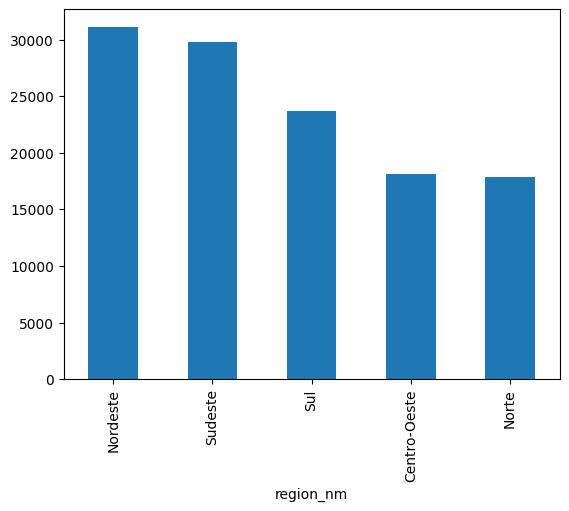

In [6]:
df['region_nm'].value_counts().plot(kind='bar')
plt.show()

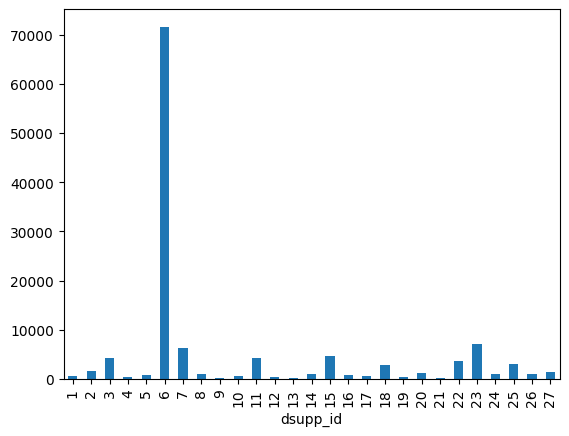

In [7]:
df['dsupp_id'].value_counts().sort_index().plot(kind='bar')
plt.show()

<Axes: >

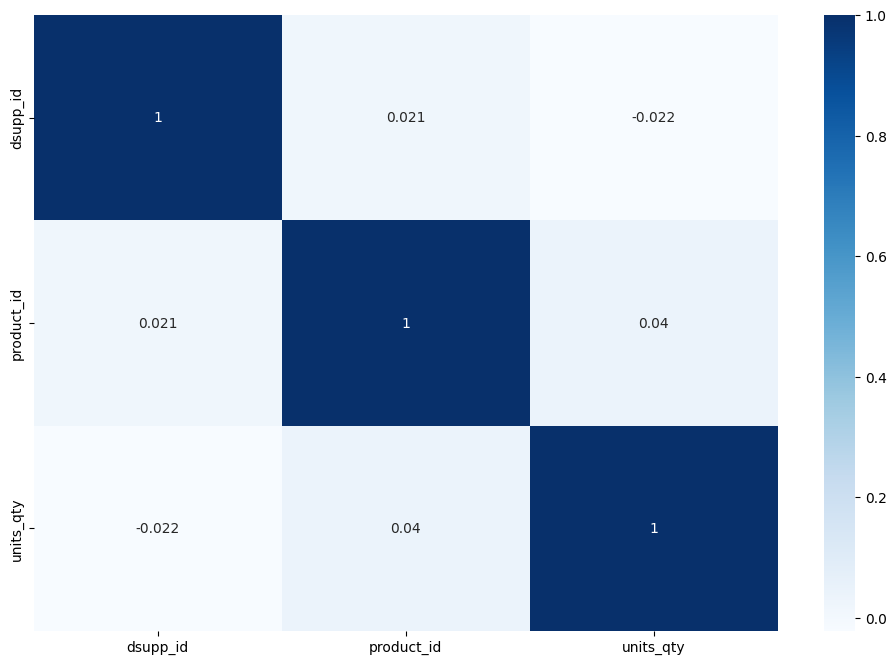

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')

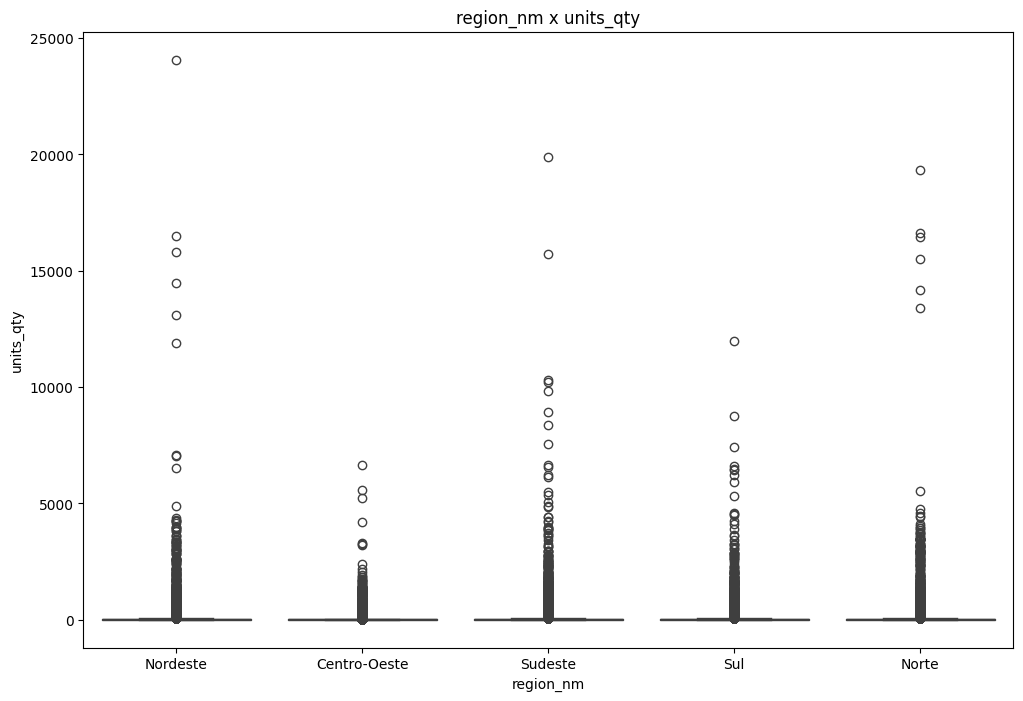

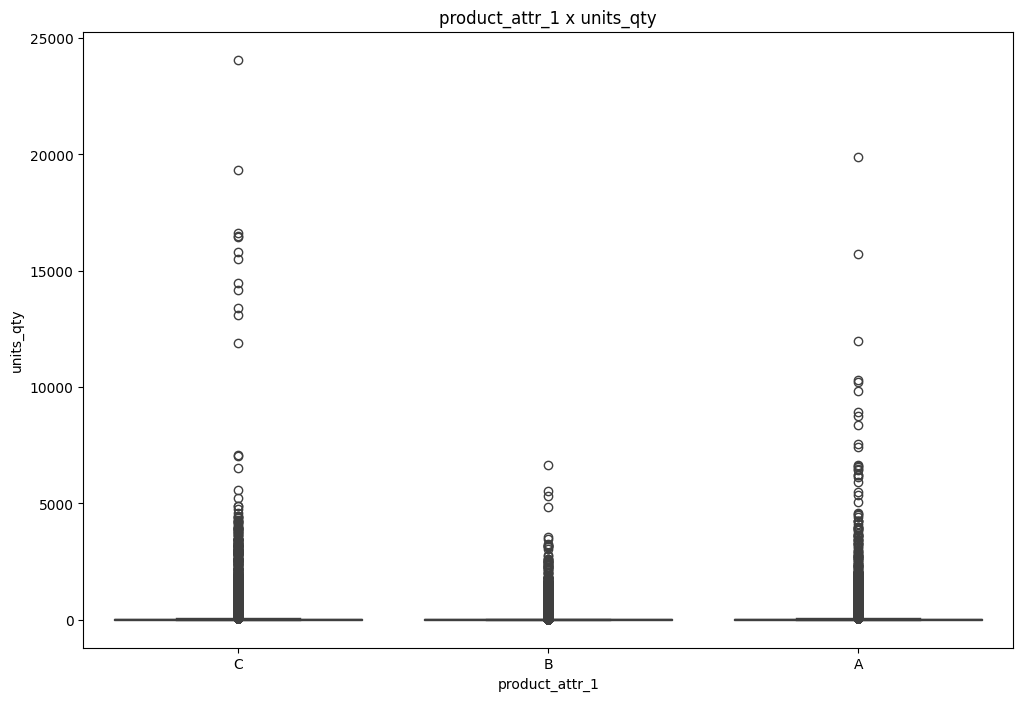

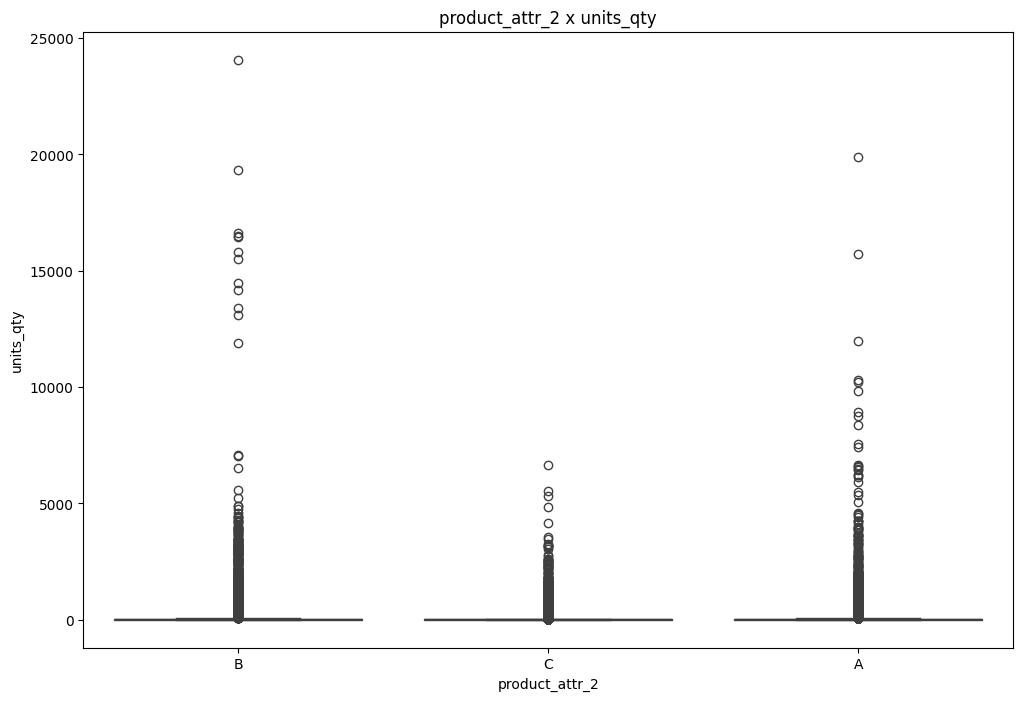

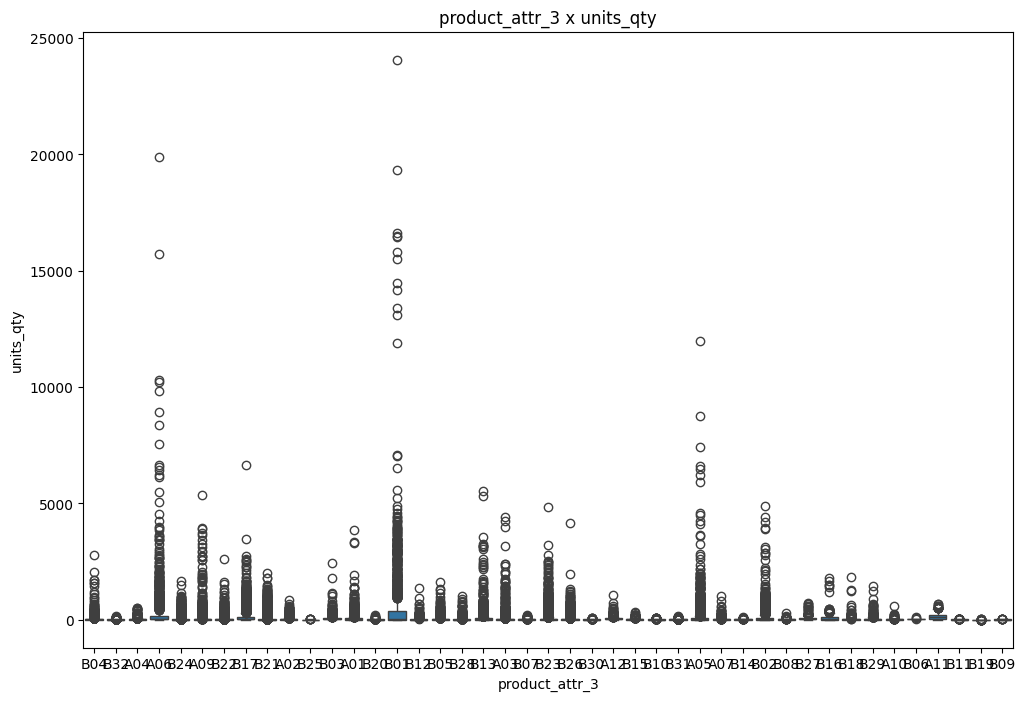

In [9]:
columns = ['region_nm', 'product_attr_1', 'product_attr_2', 'product_attr_3']

for column in columns:
    plt.figure(figsize=(12,8))
    sns.boxplot(x=column, y='units_qty', data=df)
    plt.title(f"{column} x units_qty")
    plt.show()

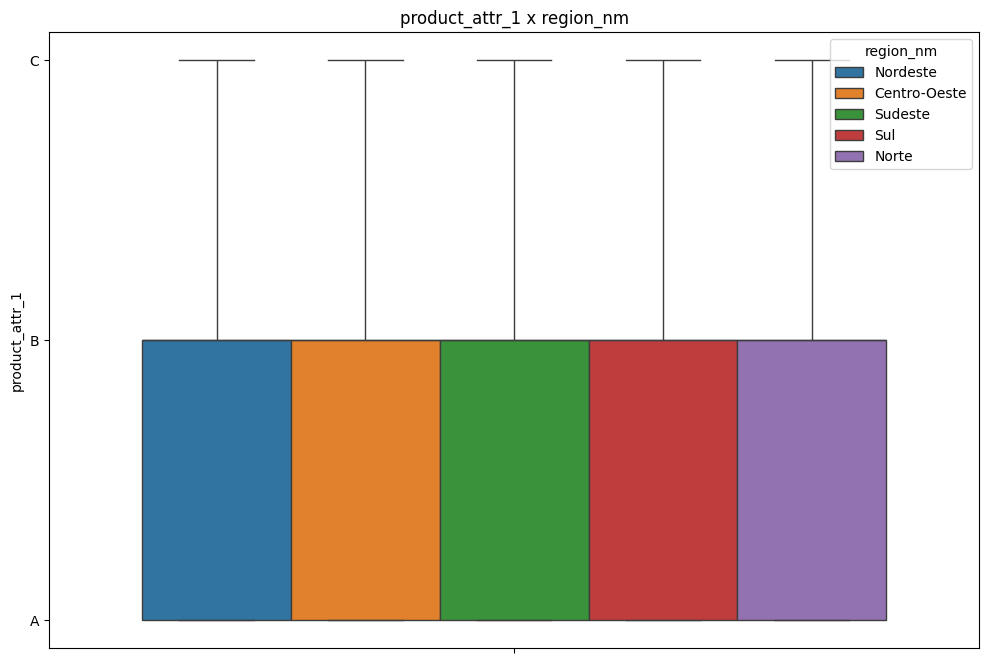

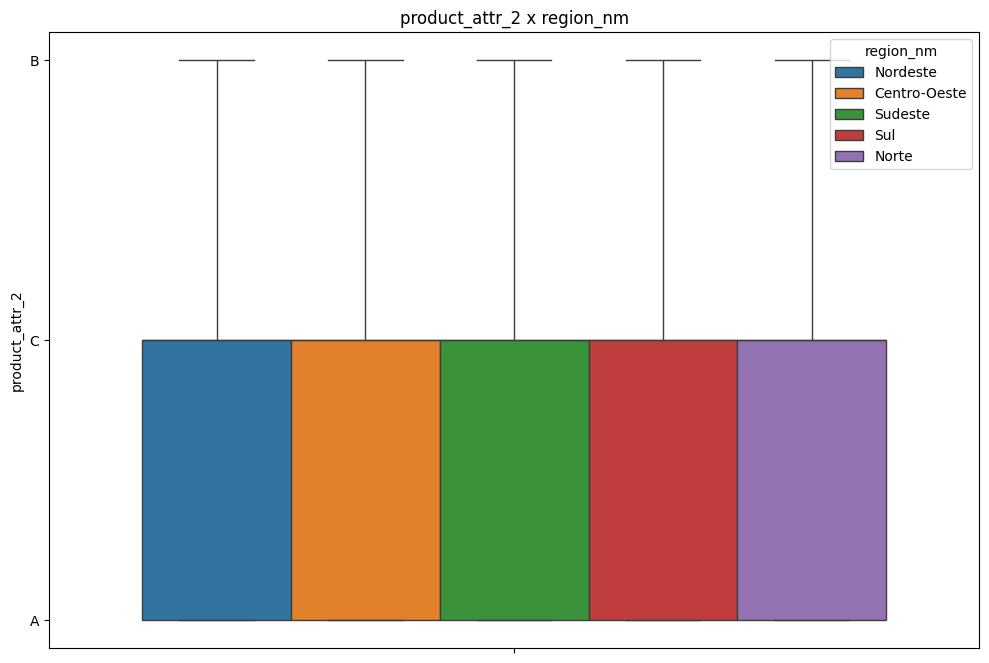

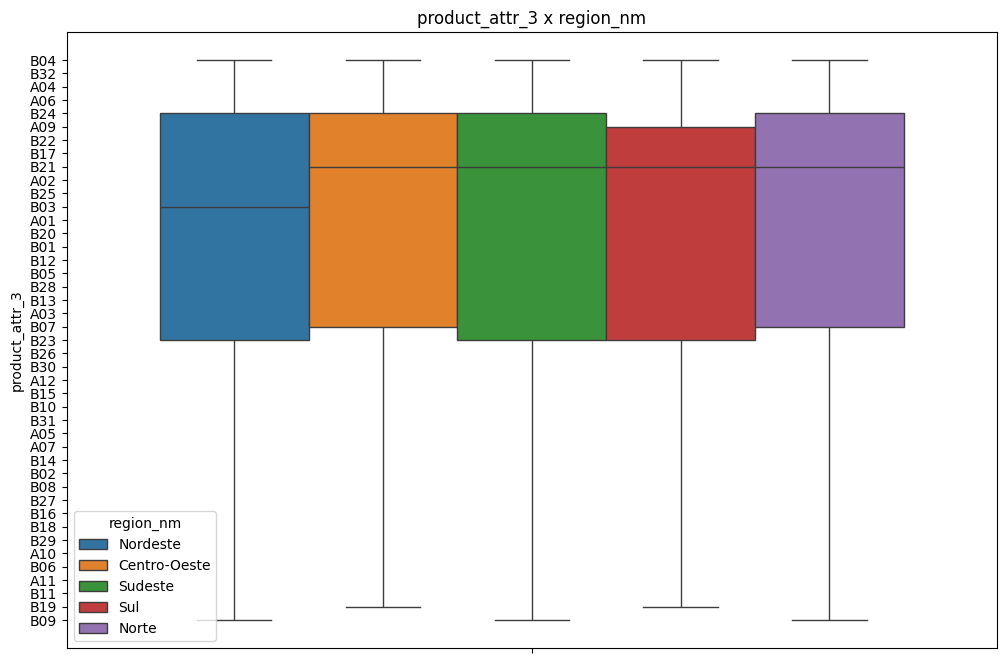

In [10]:
columns = ['product_attr_1', 'product_attr_2', 'product_attr_3']

for column in columns:
    plt.figure(figsize=(12,8))
    sns.boxplot(y=column, hue='region_nm', data=df)
    plt.title(f"{column} x region_nm")
    plt.show()

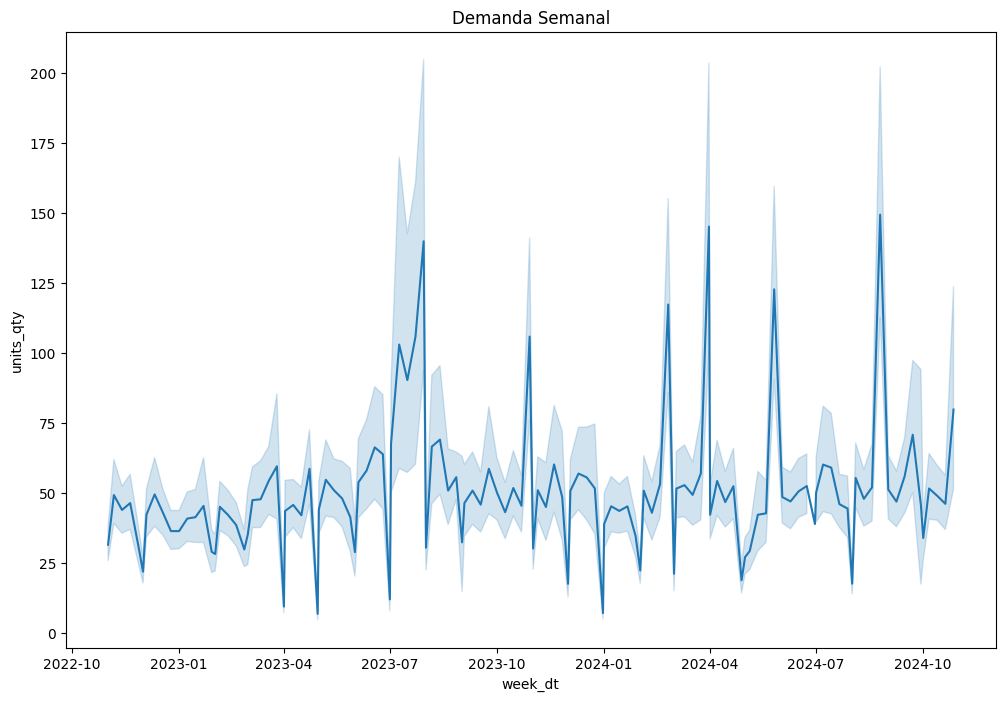

In [11]:
plt.figure(figsize=(12,8))
sns.lineplot(x='week_dt', y='units_qty', data=df)
plt.title("Demanda Semanal")
plt.show()

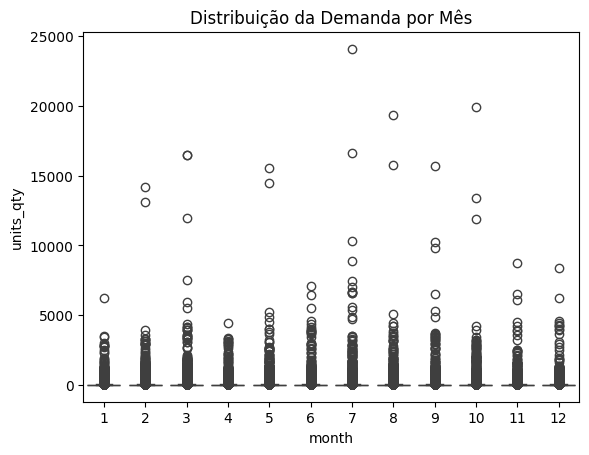

In [12]:
df['month'] = df['week_dt'].dt.month
sns.boxplot(x='month', y='units_qty', data=df)
plt.title('Distribuição da Demanda por Mês')
plt.show()

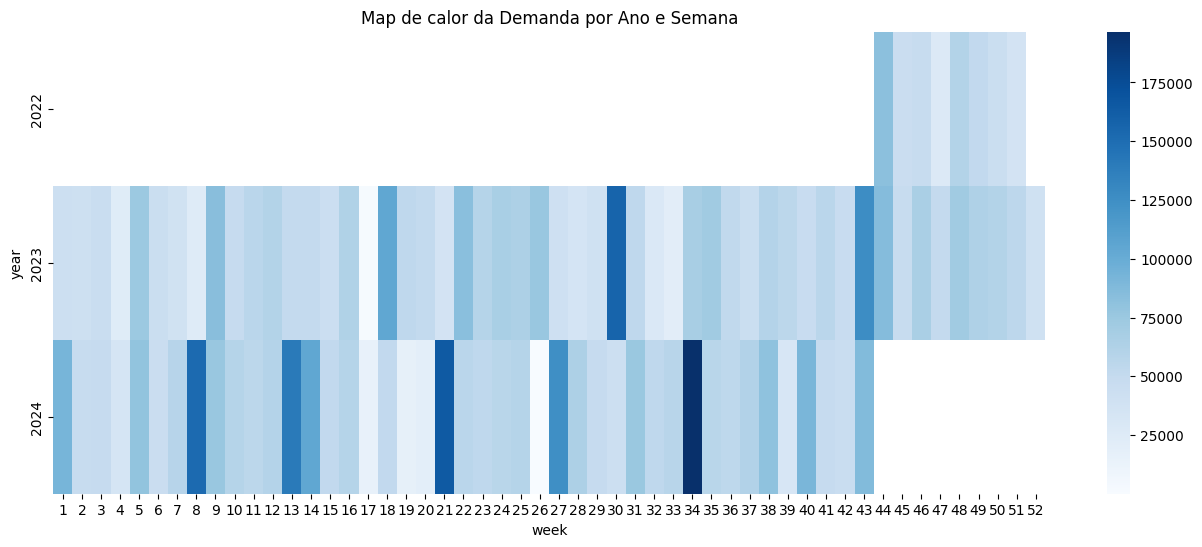

In [13]:
df['year'] = df['week_dt'].dt.year
df['week'] = df['week_dt'].dt.isocalendar().week
pivot = df.pivot_table(values='units_qty', index='year', columns='week', aggfunc='sum')

plt.figure(figsize=(16, 6))
sns.heatmap(pivot, cmap='Blues', annot=False)
plt.title("Map de calor da Demanda por Ano e Semana")
plt.show()

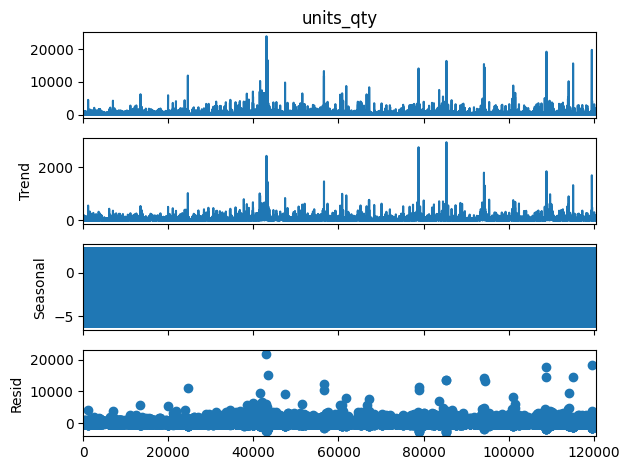

In [14]:
decomp = seasonal_decompose(df['units_qty'], model='additive', period=12)
decomp.plot()
plt.show()

---

# Conclusão

- Podemos levar em consideração que o maior números de demanadas se deve as regiões do `Nordeste` e `Sudeste`.
- Há presença de outliers na maior parde em regiões de `Nordeste`, `Sudeste` e `Norte`, o que pode indiciar certos eventos exclusivos que pode ocorrer nessas regiões (promoção, surto de doença).
- O distribuidor `6` possui o maior número de demandas
- Há também presença de outliers em algumas categorias dos produtos, o que indica que existem certos atributos com maior demanada
---
- No gráfico da `Demanda Semanal`:
    - não há uma tendência clara de alta 
    - Há picos a cada 2-3 meses, que pode representar uma sazonalidade
    - Esses picos podem estar associados a ciclos promocionais, datas sazonais do setor farmacêutico (ex: campanhas de vacinação, início de inverno/verão), ou renovação de estoque dos distribuidores.
    - Existência de outliers, acima de 150.
    - Apesar de um tendência não muita clara, visualmente não apresenta uma série estacionaria
---
- No gráfico `Decompose`:
    - O padrão é altamente variável, o que indica que não há uma tendência forte e estável de crescimento ou queda. A variação é mais influenciada por eventos pontuais do que por uma evolução constante.
    - Não foi detectado um padrão sazonal significativo com o período utilizado.

---

# Pré-processamento

## Feature Engineering

- Adicionando colunas temporais, lag features & rolling means

In [15]:
df['month'] = df['week_dt'].dt.month
df['year'] = df['week_dt'].dt.year
df['week'] = df['week_dt'].dt.isocalendar().week

for lag in [1, 2, 3, 4, 5, 6, 12]:
    df[f'lag_{lag}'] = df.groupby(['dsupp_id', 'region_nm'])['units_qty'].shift(lag)

df['rolling_mean_3'] = df.groupby(['dsupp_id', 'region_nm'])['units_qty'].shift(1).rolling(window=3).mean()
df['rolling_mean_6'] = df.groupby(['dsupp_id', 'region_nm'])['units_qty'].shift(1).rolling(window=6).mean()
df['rolling_mean_9'] = df.groupby(['dsupp_id', 'region_nm'])['units_qty'].shift(1).rolling(window=9).mean()

In [16]:
# Remoção do product_id, será utilizado apenas os atributos dos produtos como informações.
df.drop('product_id', axis=1, inplace=True)

In [17]:
np.unique(df['region_nm'])

array(['Centro-Oeste', 'Nordeste', 'Norte', 'Sudeste', 'Sul'],
      dtype=object)

In [18]:
np.unique(df['dsupp_id'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27], dtype=int64)

In [19]:
np.unique(df['product_attr_1'])

array(['A', 'B', 'C'], dtype=object)

In [20]:
np.unique(df['product_attr_2'])

array(['A', 'B', 'C'], dtype=object)

In [21]:
np.unique(df['product_attr_3'])

array(['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A09', 'A10',
       'A11', 'A12', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07',
       'B08', 'B09', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16',
       'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25',
       'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32'], dtype=object)

In [22]:
df = pd.get_dummies(data=df, columns=['region_nm', 'dsupp_id', 'product_attr_1', 'product_attr_2', 'product_attr_3'], dtype=int)

In [24]:
df

,week_dt,units_qty,month,year,week,lag_1,lag_2,lag_3,lag_4,lag_5,...,product_attr_3_B23,product_attr_3_B24,product_attr_3_B25,product_attr_3_B26,product_attr_3_B27,product_attr_3_B28,product_attr_3_B29,product_attr_3_B30,product_attr_3_B31,product_attr_3_B32
0,2022-11-01,13.0,11,2022,44,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2022-11-01,26.0,11,2022,44,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2,2022-11-01,2.0,11,2022,44,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2022-11-01,9.0,11,2022,44,2.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
4,2022-11-01,4.0,11,2022,44,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120585,2024-10-27,36.0,10,2024,43,13.0,21.0,2.0,1.0,7.0,...,0,0,0,0,0,0,0,0,0,0
120586,2024-10-27,109.0,10,2024,43,36.0,13.0,21.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
120587,2024-10-27,6.0,10,2024,43,109.0,36.0,13.0,21.0,2.0,...,0,0,0,0,0,1,0,0,0,0
120588,2024-10-27,7.0,10,2024,43,1.0,1.0,155.0,14.0,2.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# modelo preditivo para prever a demanda dos produtos por distribuidor e região geográfica das lojas responsáveis pelas vendas.

---

# Fontes de Apoio

- [Time Series Plot](https://www.mathworks.com/help/matlab/ref/timeseries.plot.html)
- [Seasonal Decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)
- [Preprocessing Time Series](https://www.nousot.com/resources/preprocessing-for-time-series/)